In [1]:
cd /home

/home


# Results experiments

###### by Cristobal Donoso-Oliva et.al., 2022

In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import pandas as pd
import numpy as np
import tomli
import os 

from src.pipeline.base import load_pt_data, compile_astromer
from src.models        import get_ASTROMER_2, get_ASTROMER
from src.utils import get_metrics

%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

# plt.style.use('dark_background')|

In [3]:
def collect_metrics(config_files_folder, step='classification', cases=['a', 'b']):
    '''
    Concatenate dataframes containing testing/validation metrics.'
    '''
    metrics_list = []
    for sci_case in cases:
        for file in os.listdir(config_files_folder):
            if sci_case != file.split('.')[3]:
                continue
            fold_n = file.split('.')[2].split('f')[-1]
            ft_data = file.split('.')[0]

            current = os.path.join(config_files_folder, file)
            with open(current, mode="rb") as fp:
                config = tomli.load(fp)

            if step == 'pretraining':
                metrics = pd.read_csv(os.path.join(config[step]['exp_path'], 'metrics.csv'))
                return metrics
            try:
                metrics = pd.read_csv(os.path.join(config[step]['exp_path'], 'metrics.csv'))
                metrics['ft_data']  = [ft_data]*metrics.shape[0]
                metrics['fold'] = [fold_n]*metrics.shape[0]
                metrics['file']  = [file]*metrics.shape[0]
                metrics['case']  = [sci_case]*metrics.shape[0]
                metrics_list.append(metrics)

            except Exception as e:
                continue
    return pd.concat(metrics_list)

## Pretraining results

First we take an arbitrary config file from the `experiments_config_files` folder

In [4]:
mean_rmse = []
mean_rsquare = []
for base in [1, 2]:
    experiments_config_files = f'./presentation/experiments/astromer_2/config_files/alcock_pe_{base}/'
    with open(os.path.join(experiments_config_files, os.listdir(experiments_config_files)[0]), mode="rb") as fp:
        config = tomli.load(fp)
        
    metrics = collect_metrics(experiments_config_files, step='pretraining')
    loss = metrics['rmse'].values[0]
    r2 = metrics['r_square'].values[0]
    
    mean_rmse.append(loss)
    mean_rsquare.append(r2)

Text(0.5, -0.05, 'Exponent $\\alpha$ from $base^{(\\alpha j/D_{pe})}$ the positional encoder')

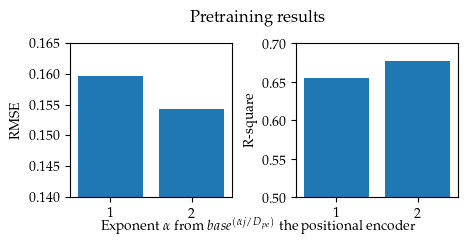

In [5]:
fig, axes = plt.subplots(1, 2, sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.4}, figsize=(5, 2))

x_range = np.arange(0, 2)
axes[0].bar(x_range, mean_rmse)
axes[0].set_ylim(0.14, 0.165)

axes[1].bar(x_range, mean_rsquare)
axes[1].set_xticks(x_range, [1, 2])
axes[1].set_ylim(0.5, 0.7)

axes[0].set_ylabel('RMSE')
axes[1].set_ylabel('R-square')

fig.suptitle('Pretraining results', x=0.5, y=1.05)
fig.text(0.5, -0.05, r'Exponent $\alpha$ from $base^{(\alpha j/D_{pe})}$ the positional encoder', ha='center')

In [6]:
'./presentation/experiments/astromer_2/config_files/macho/'

'./presentation/experiments/astromer_2/config_files/macho/'

{'general': {'code_root': '.', 'creation_date': '2023-01-25', 'gpu': 0}, 'astromer': {'layers': 2, 'heads': 4, 'head_dim': 64, 'dff': 128, 'dropout': 0.1, 'window_size': 200, 'pe_c': 2.0}, 'masking': {'mask_frac': 0.5, 'rnd_frac': 0.2, 'same_frac': 0.2}, 'positional': {'base': 1000, 'version': 'v1'}, 'pretraining': {'exp_path': './presentation/experiments/astromer_2/results/macho_2/pretraining', 'lr': 0.001, 'scheduler': True, 'epochs': 10000, 'patience': 40, 'data': {'path': './data/records/macho', 'batch_size': 2500, 'repeat': 4, 'sampling': True, 'normalize': True, 'shuffle_train': True, 'shuffle_val': False, 'shuffle_test': False, 'cache_train': True, 'cache_val': True, 'cache_test': False}}, 'finetuning': {'exp_path': './presentation/experiments/astromer_2/results/macho_2/alcock/finetuning/alcock_20_f0', 'weights': './presentation/experiments/astromer_2/results/macho_2/pretraining', 'lr': 0.001, 'scheduler': True, 'epochs': 10000, 'patience': 20, 'batch_size': 2500, 'data': {'path

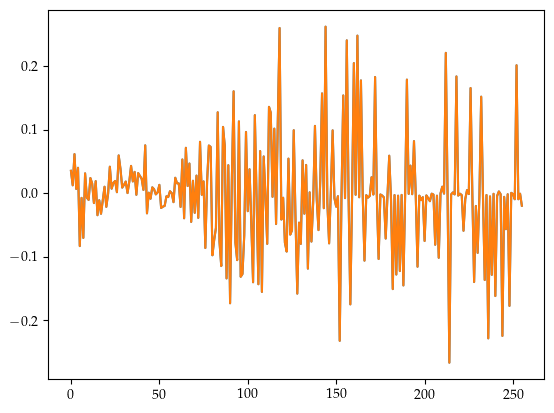

In [9]:
for base in [1, 2]:
    experiments_config_files = f'./presentation/experiments/astromer_2/config_files/macho_2/'
    with open(os.path.join(experiments_config_files, os.listdir(experiments_config_files)[0]), mode="rb") as fp:
        config = tomli.load(fp)
        print(config)
    d_model = config['astromer']['head_dim']*config['astromer']['heads']
    astromer =  get_ASTROMER(num_layers=config['astromer']['layers'],
                             d_model=d_model,
                             num_heads=config['astromer']['heads'],
                             dff=config['astromer']['dff'],
                             base=config['positional']['base'],
                             dropout=config['astromer']['dropout'],
                             maxlen=config['astromer']['window_size'])
    
    astromer = compile_astromer(config, astromer, step='pretraining')
    astromer.load_weights(os.path.join(config['finetuning']['weights'], 'weights'))
    encoder = astromer.get_layer('encoder')
    
    W = encoder.inp_transform.weights[0]

    plt.plot(W[0])

## Finetuning results

Use `collect_metrics` to join all the metrics associated with the experiments in 
`./presentation/pipeline/config/<experiment>`

By default it gives **finetuning** metrics. Use `clasification=True` for getting classification metrics 

In [10]:
experiments_config_files

'./presentation/experiments/astromer_0/config_files/ztfg/'

In [11]:
metrics_ft = collect_metrics(experiments_config_files, step='finetuning')

In [12]:
metrics_ft.groupby('case').mean()

,rmse,r_square
case,,
a,0.120343,0.70457
b,0.120343,0.70457


## Metrics by number of samples per class

Defining plot styles for the classifiers

In [13]:
styles = {'MLP+ATT':{'marker':'^', 'linestyle':'-'}, 
          'LSTM+ATT':{'marker':'o', 'linestyle':'--'}, 
          'Baseline':{'marker':'s', 'linestyle':':'}}

ft_names_changed = {
    'alcock': 'MACHO', 'atlas': 'ATLAS', 'ogle':'OGLE-III'
}

In [14]:
selected_metric = 'f1'
experiments_config_files

'./presentation/experiments/astromer_0/config_files/ztfg/'

In [20]:
root_path_exp = './presentation/experiments/astromer_0/config_files/ztfg/'

In [21]:
for x in ['alcock_pe_1', 'alcock_pe_2']:
    current_path = os.path.join(root_path_exp, x)
    metrics = collect_metrics(experiments_config_files, step='classification', cases=['a'])
    
    for row, (dataset_name, frame_0) in enumerate(metrics.groupby('ft_data')):
        print(dataset_name)
        metrics_by_case = frame_0.groupby('case')
        for col, (sci_case, frame_1) in enumerate(metrics_by_case):
            metrics_by_model = frame_1.groupby('model')
            best_baseline = []
            
            for model_name, frame_2 in metrics_by_model:
                frame_2['spc'] = frame_2['file'].apply(lambda x: int(x.split('.')[1]))
                metrics_by_spc = frame_2.groupby('spc')
                model_metrics = []
                for spc, frame_3 in metrics_by_spc:
                    mean = frame_3['f1'].astype(float).mean()
                    std = frame_3['f1'].astype(float).std()
                    model_metrics.append((float(spc), mean, std))
                
                sorted_metrics = sorted(model_metrics, key=lambda tup: tup[0])
                sorted_metrics = np.vstack(sorted_metrics)
                print(sorted_metrics)

alcock
[[2.00000000e+01 3.36127662e-01 4.44041381e-02]
 [5.00000000e+01 4.17980672e-01 1.34888005e-02]
 [1.00000000e+02 4.68271158e-01 2.30641729e-02]
 [5.00000000e+02 6.45873496e-01 2.82333639e-03]]
[[2.00000000e+01 5.69618000e-01 3.49292240e-02]
 [5.00000000e+01 6.58555778e-01 1.40514994e-02]
 [1.00000000e+02 6.72187296e-01 1.91494052e-02]
 [5.00000000e+02 7.40409658e-01 1.23295262e-02]]
[[2.00000000e+01 2.48189980e-01 1.74371940e-01]
 [5.00000000e+01 5.57495629e-01 7.98961842e-03]
 [1.00000000e+02 5.78384842e-01 1.91648168e-02]
 [5.00000000e+02 6.59343050e-01 1.84990873e-02]]
atlas
[[2.00000000e+01 3.77201609e-01 5.41519803e-02]
 [5.00000000e+01 4.21944569e-01 4.34956015e-02]
 [1.00000000e+02 4.96874742e-01 2.42267475e-02]
 [5.00000000e+02 6.29487078e-01 1.26337779e-02]]
[[2.00000000e+01 4.77840782e-01 1.66790739e-02]
 [5.00000000e+01 5.75366907e-01 1.96795365e-02]
 [1.00000000e+02 6.15172204e-01 1.98695885e-02]
 [5.00000000e+02 7.06005078e-01 2.65088166e-02]]
[[2.00000000e+01 4.608

In [34]:
experiments_config_files = './presentation/experiments/astromer_0/config_files/macho/'

    precision    recall        f1   val_acc  val_loss     model ft_data fold  \
0    0.343724  0.325747  0.300260  0.410526  1.507451   mlp_att  alcock    0   
1    0.533899  0.533286  0.529286  0.684211  1.010897  lstm_att  alcock    0   
2    0.321222  0.311473  0.286605  0.484211  1.529895      lstm  alcock    0   
0    0.528288  0.509542  0.507028  0.574074  1.113987   mlp_att   atlas    1   
1    0.603892  0.593140  0.594388  0.629630  1.135675  lstm_att   atlas    1   
..        ...       ...       ...       ...       ...       ...     ...  ...   
1    0.612775  0.608571  0.609662  0.715686  0.765815  lstm_att   atlas    2   
2    0.503477  0.521731  0.505325  0.598039  1.032293      lstm   atlas    2   
0    0.516678  0.525710  0.514673  0.555556  1.602320   mlp_att    ogle    1   
1    0.544777  0.548452  0.542414  0.596491  1.413167  lstm_att    ogle    1   
2    0.307743  0.303579  0.290549  0.321637  1.835665      lstm    ogle    1   

                   file case  
0   alco

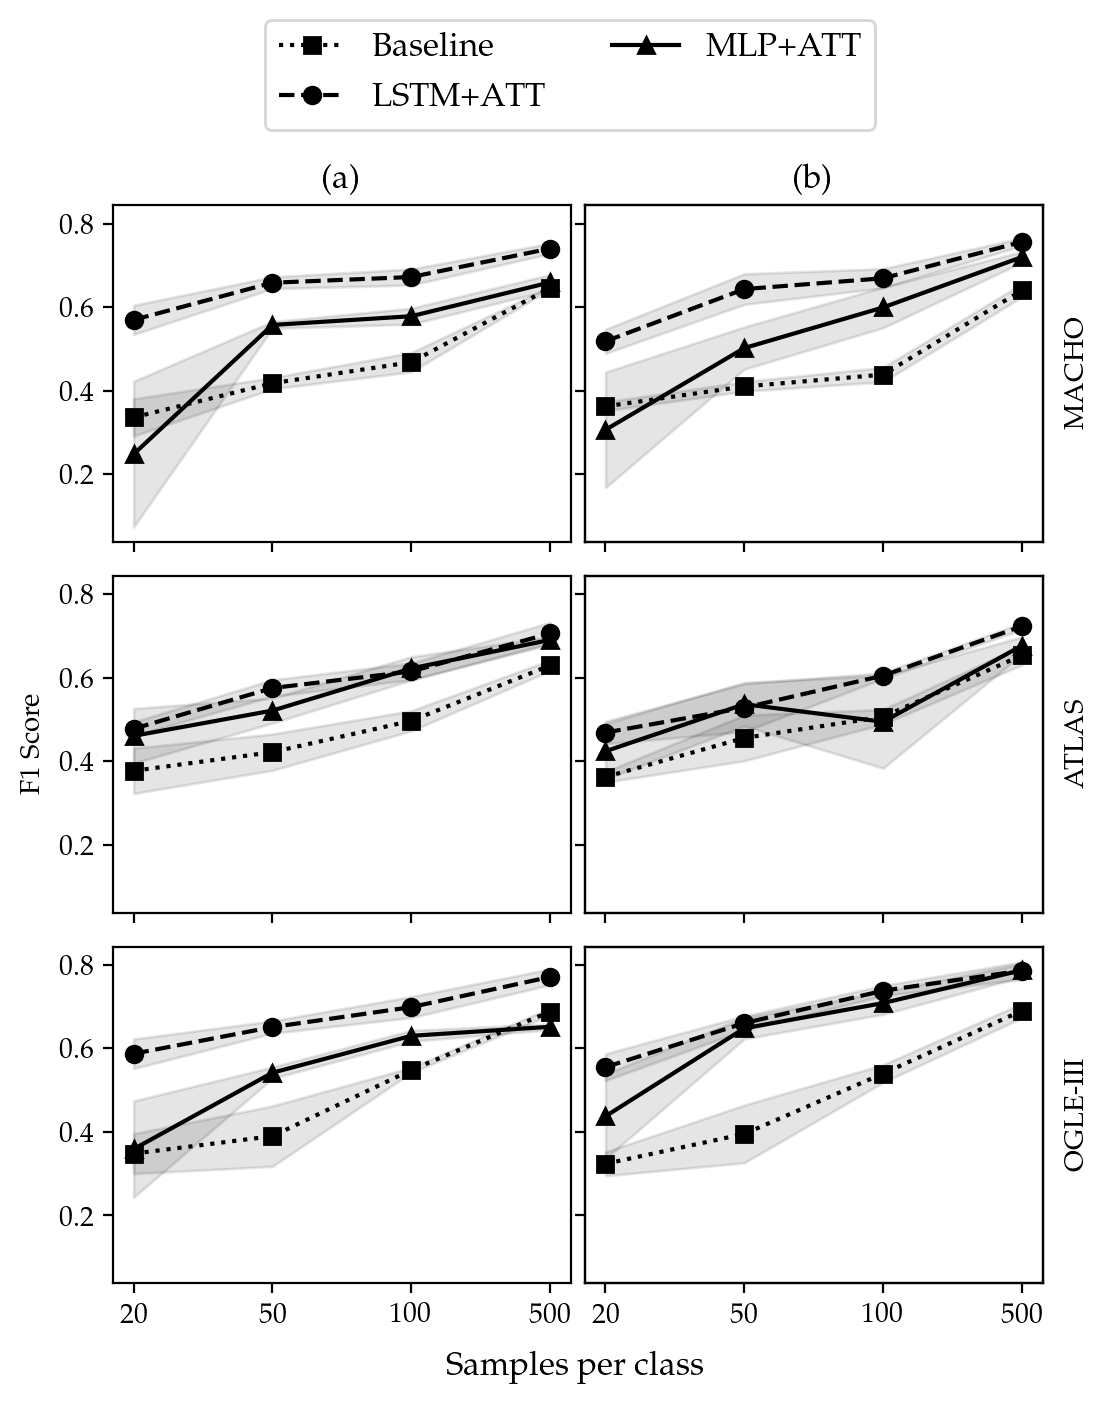

In [38]:
fig, axes = plt.subplots(3,2, figsize=(6,7), 
                         gridspec_kw={'hspace': 0.1, 'wspace': 0.03},
                         sharey=True, sharex=True, dpi=200)

for master_name in ['ztfg']:
    experiments_config = './presentation/experiments/astromer_0/config_files/'+master_name
    metrics = collect_metrics(experiments_config, step='classification', cases=['a', 'b'])
    print(metrics)
    metrics = metrics.replace({'mlp_att':'MLP+ATT', 'lstm_att':'LSTM+ATT', 'lstm':'Baseline'})
    
    
    for row, (dataset_name, frame_0) in enumerate(metrics.groupby('ft_data')):
        metrics_by_case = frame_0.groupby('case')
        for col, (sci_case, frame_1) in enumerate(metrics_by_case):

            metrics_by_model = frame_1.groupby('model')
            best_baseline = []
            for model_name, frame_2 in metrics_by_model:                    
                frame_2['spc'] = frame_2['file'].apply(lambda x: int(x.split('.')[1]))

                metrics_by_spc = frame_2.groupby('spc')
                model_metrics = []
                for spc, frame_3 in metrics_by_spc:
                    mean = frame_3[selected_metric].astype(float).mean()
                    std = frame_3[selected_metric].astype(float).std()
                    model_metrics.append((float(spc), mean, std))

                sorted_metrics = sorted(model_metrics, key=lambda tup: tup[0])
                sorted_metrics = np.vstack(sorted_metrics)
                
                x_range = range(len(sorted_metrics[:, 0]))
                axes[row][col].plot(x_range, 
                               sorted_metrics[:, 1], 
                               marker=styles[model_name]['marker'], 
                               color='k',
                               linestyle=styles[model_name]['linestyle'],
                               label=model_name)
                axes[row][col].fill_between(x_range, 
                                       sorted_metrics[:, 1]+sorted_metrics[:, 2], 
                                       sorted_metrics[:, 1]-sorted_metrics[:, 2],
                                       color='k', alpha=0.1)
                axes[row][col].set_xticks(x_range)
                axes[row][col].set_xticklabels([int(x) for x in sorted_metrics[:, 0]])
                
                if model_name == 'Baseline':
                    best_baseline.append(np.max(sorted_metrics[:, 1]))
    
            if col == 1:
                ax2 = axes[row][col].twinx()     
                ax2.set_yticks([])
                ax2.set_ylabel(ft_names_changed[dataset_name])

#             axes[row][col].axhline(y=np.max(best_baseline), 
#                                    color='red', 
#                                    linestyle='--', 
#                                    linewidth=1, 
#                                    label='Best Baseline')
#             axes[row][col].set_yticks([round(x, 1) for x in np.linspace(0.1, 0.8, 10)])
            
axes[0][0].set_title('(a)')
axes[0][1].set_title('(b)')
axes[1][0].set_ylabel('F1 Score')

axes[0][0].legend(ncol=2, bbox_to_anchor = (1.7, 1.6), fontsize=12)
if selected_metric == 'acc':
    axes[0][0].set_ylabel('Accuracy', fontsize=12)


fig.text(0.51, 0.05, 'Samples per class', ha='center', va='center', fontsize=12)
plt.show()